In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cv10_labels.npy
/kaggle/input/test10_labels.npy
/kaggle/input/training10_1/training10_1.tfrecords
/kaggle/input/cv10_data/cv10_data.npy
/kaggle/input/test10_data/test10_data.npy
/kaggle/input/training10_3/training10_3.tfrecords
/kaggle/input/training10_2/training10_2.tfrecords
/kaggle/input/training10_0/training10_0.tfrecords
/kaggle/input/training10_4/training10_4.tfrecords


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_cv
import math

2025-06-09 08:49:55.395996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749458995.587537      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749458995.642567      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = 299
CHANNELS = 1

def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 1])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    label = parsed_features['label']

    label = tf.one_hot(label, 5, dtype=tf.float32)

    return image, label

In [6]:
def create_dataset(tfrecord_files, batch_size=BATCH_SIZE):
    """Create dataset from TFRecord files"""
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
def create_numpy_dataset(data_path, labels_path, batch_size=BATCH_SIZE, is_training=False):
    if isinstance(data_path, str):
        data = np.load(data_path, mmap_mode='r')
        labels = np.load(labels_path, mmap_mode='r')
    else:
        data = data_path
        labels = labels_path

    def generator():
        for i in range(len(data)):
            # Process image
            image = data[i].reshape(IMG_SIZE, IMG_SIZE, 1)
            image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
            #image = image.astype('uint8')
            image = tf.cast(image, tf.float32) / 255.0

            label_index = labels[i]
            one_hot_label = np.zeros(5, dtype=np.float32)
            one_hot_label[label_index] = 1.0

            yield image, one_hot_label

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(5,), dtype=tf.float32)
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords

In [14]:
import os

# List all files under the input directory
for root, dirs, files in os.walk('/kaggle/input/'):
    for file in files:
        print(os.path.join(root, file))


/kaggle/input/cv10_labels.npy
/kaggle/input/test10_labels.npy
/kaggle/input/training10_1/training10_1.tfrecords
/kaggle/input/cv10_data/cv10_data.npy
/kaggle/input/test10_data/test10_data.npy
/kaggle/input/training10_3/training10_3.tfrecords
/kaggle/input/training10_2/training10_2.tfrecords
/kaggle/input/training10_0/training10_0.tfrecords
/kaggle/input/training10_4/training10_4.tfrecords


In [9]:
import numpy as np
import tensorflow as tf

print("Loading training dataset...")
train_files = ['/kaggle/input/training10_1/training10_1.tfrecords']
train_dataset = create_dataset(train_files, BATCH_SIZE)

# Extract labels from train_dataset
train_labels_list = []

for _, labels in train_dataset:
    label_indices = np.argmax(labels.numpy(), axis=1)
    train_labels_list.extend(label_indices)

train_labels = np.array(train_labels_list)

# Function to compute class weights
def compute_class_weights(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = np.sum(counts)
    num_classes = len(class_names)

    # Raw frequency-based inverse weighting
    beta = total_samples / (num_classes * counts)

    print("\nTraining Set Label Distribution and Class Weights (Beta):")
    for i, count in zip(unique, counts):
        print(f"{class_names[i]}: count={count}, beta={beta[i]:.4f}")
    
    return dict(zip(unique, beta))

# Define class names
#class_names = ['Normal', 'Benign Calc', 'Benign Mass', 'Malignant Calc', 'Malignant Mass']



class_names = ['Negative', 'Benign Calcification', 'Benign Mass',
               'Malignant Calcification', 'Malignant Mass']

# Compute and print class weights
train_class_weights = compute_class_weights(train_labels, class_names)

train_beta = np.array(list(train_class_weights.values()))
train_beta

Loading training dataset...


I0000 00:00:1749459107.865506      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training Set Label Distribution and Class Weights (Beta):
Negative: count=9751, beta=0.2292
Benign Calcification: count=424, beta=5.2722
Benign Mass: count=346, beta=6.4607
Malignant Calcification: count=287, beta=7.7889
Malignant Mass: count=369, beta=6.0580


array([0.22924828, 5.27216981, 6.46069364, 7.78885017, 6.05799458])

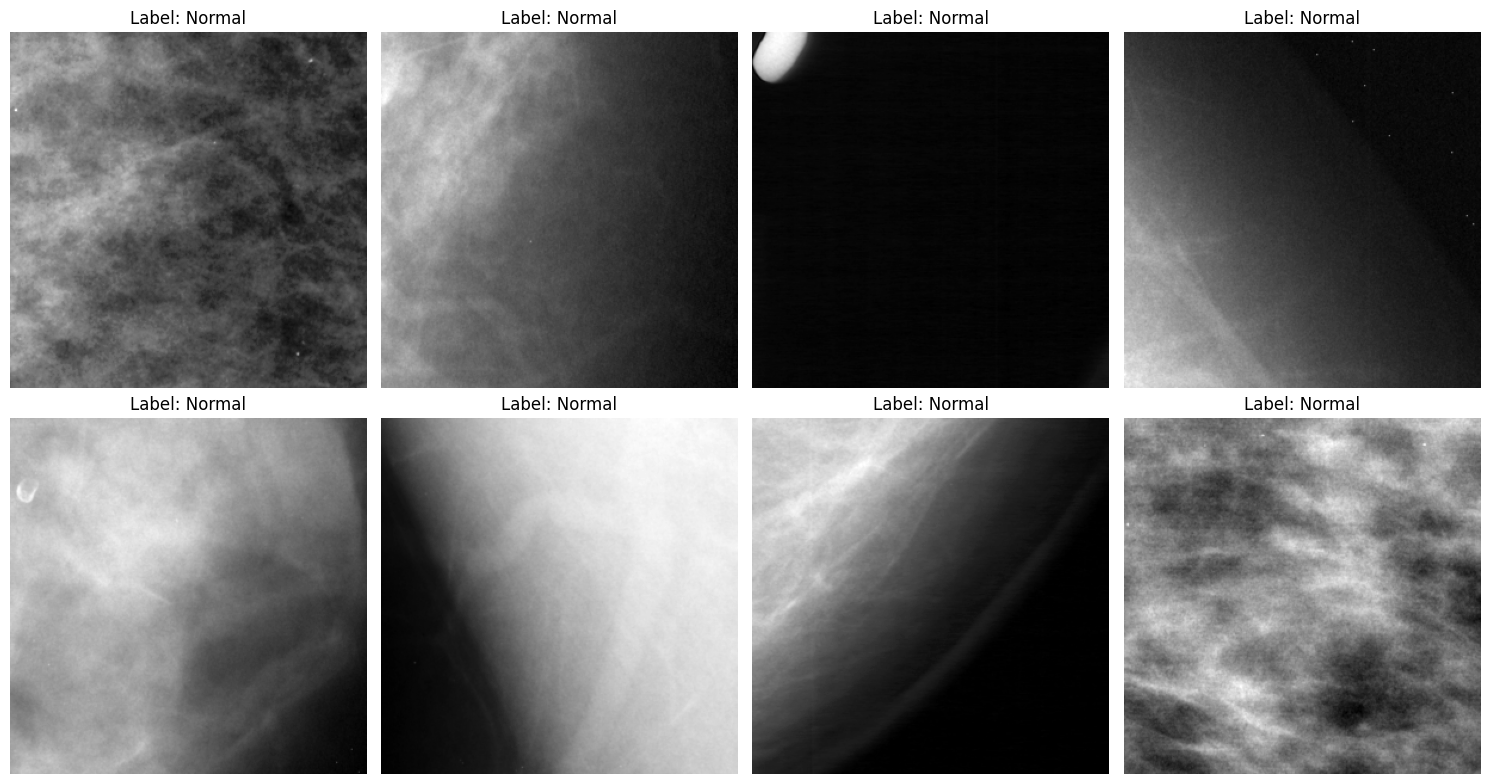

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def display_batch(dataset, num_images=8):
    """
    Display images from a batch of the dataset
    """
    # Get one batch
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 8))
        
        # Display up to num_images from the batch
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 4, i + 1)
            
            # Convert tensor to numpy and display
            img = images[i].numpy()
            label = np.argmax(labels[i].numpy())
            
            # Map label index to class name
            label_names = ['Normal', 'Abnormal Type 1', 'Abnormal Type 2', 
                         'Abnormal Type 3', 'Abnormal Type 4']
            title = f'Label: {label_names[label]}'
            
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Display images from your dataset
display_batch(train_dataset)

# To display multiple batches, you can use:
#for batch in train_dataset.take(10):
#    display_batch(train_dataset)

In [11]:
#Validation et Test Data needs to be combined to mix Masses and Calcifications
print("Loading and combining validation/test data...")
test_data = np.load('/kaggle/input/test10_data/test10_data.npy', mmap_mode='r')
test_labels = np.load('/kaggle/input/test10_labels.npy', mmap_mode='r')

cv_data = np.load('/kaggle/input//cv10_data/cv10_data.npy', mmap_mode='r')
cv_labels = np.load('/kaggle/input/cv10_labels.npy', mmap_mode='r')

combined_data = np.concatenate([test_data, cv_data])
combined_labels = np.concatenate([test_labels, cv_labels])

#Shuffling the Data
#np.random.shuffle(combined_data)
indices = np.random.permutation(len(combined_data))
combined_data = combined_data[indices]
combined_labels = combined_labels[indices]

Loading and combining validation/test data...


In [12]:
val_split = int(len(combined_data) * 0.65)
val_dataset = create_numpy_dataset(
    combined_data[:val_split],
    combined_labels[:val_split],
    BATCH_SIZE,
    is_training=False
)




test_dataset = create_numpy_dataset(
    combined_data[val_split:],
    combined_labels[val_split:],
    BATCH_SIZE,
    is_training=False
)



# Extract validation labels for use in evaluation/prediction
val_labels = combined_labels[val_split:]  # ✅ This is what you use in model.predict comparison





class_names = ['Negative', 'Benign Calcification', 'Benign Mass',
               'Malignant Calcification', 'Malignant Mass']

print(train_dataset.take(1))
print(val_dataset.take(2))

def print_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    dist = dict(zip(unique, counts))
    print("\nLabel distribution:")
    for label_idx, count in dist.items():
        print(f"{class_names[label_idx]}: {count} samples ({count/len(labels)*100:.2f}%)")

print("\nValidation set:")
print_label_distribution(combined_labels[:val_split])
print("\nTest set:")
print_label_distribution(combined_labels[val_split:])

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

Validation set:

Label distribution:
Negative: 8724 samples (87.36%)
Benign Calcification: 361 samples (3.62%)
Benign Mass: 404 samples (4.05%)
Malignant Calcification: 220 samples (2.20%)
Malignant Mass: 277 samples (2.77%)

Test set:

Label distribution:
Negative: 4636 samples (86.20%)
Benign Calcification: 197 samples (3.66%)
Benign Mass: 238 samples (4.43%)
Malignant Calcification: 149 samples (2.77%)
Malignant Mass: 158 samples (2.94%)


As we can see, the data is highly unbalanced, we need consider that during training by adjusting the weights

In [15]:
import tensorflow as tf

def create_custom_lenet(img_size, num_classes):
    """
    Custom implementation of LeNet architecture (modified for input size and breast imaging).
    No built-in LeNet package is used.
    """

    inputs = tf.keras.Input(shape=(img_size, img_size, 1))  # Assuming grayscale input

    # First convolutional layer
    x = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2)(x)

    # Second convolutional layer
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2)(x)

    # Third convolutional layer (optional for deeper features)
    x = tf.keras.layers.Conv2D(filters=120, kernel_size=(5, 5), activation='relu')(x)

    # Flatten
    x = tf.keras.layers.Flatten()(x)

    # First fully connected layer
    x = tf.keras.layers.Dense(units=84, activation='relu')(x)

    # Optional: Add dropout or batch normalization
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [19]:
 

def compile_and_prepare_model(model):
    # Learning rate schedule
    initial_learning_rate = 5e-4
    decay_steps = 1000
    decay_rate = 0.9
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )
    
    # Optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=initial_learning_rate,
        weight_decay=0.01
    )
    
    # Compile model
    model.compile(
         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # You can adjust the learning rate
         loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )
    
    return model

In [20]:
model = create_custom_lenet(img_size = 299,num_classes=5)
model = compile_and_prepare_model(model)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 299, 299, 6)         │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 149, 149, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 145, 145, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 72, 72, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 68, 68, 120)         │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 554880)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │      46,610,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,661,121 (178.00 MB)

 Trainable params: 46,661,121 (178.00 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=6,   
    min_delta=1e-7,
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1


    
)

In [23]:
history = model.fit(train_dataset,
    validation_data=val_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    
    callbacks=[early_stopping, plateau, model_checkpoint])

Epoch 1/100


I0000 00:00:1749459382.021645      93 service.cc:148] XLA service 0x7eb77400ff60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749459382.022602      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749459382.360515      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


      5/Unknown 10s 30ms/step - accuracy: 0.4525 - auc: 0.7921 - loss: 1.8455 - precision: 0.6453 - recall: 0.3680   

I0000 00:00:1749459387.831250      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    350/Unknown 23s 40ms/step - accuracy: 0.8539 - auc: 0.9433 - loss: 0.6412 - precision: 0.8801 - recall: 0.8082

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Just get test results
results = model.evaluate(test_dataset)
print("\nTest Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Get predictions for confusion matrix
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([np.argmax(labels, axis=1) 
                        for _, labels in test_dataset])

# Plot confusion matrix
class_names = ['Normal', 'Benign Calc', 'Benign Mass', 
               'Malignant Calc', 'Malignant Mass']
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.2547 - auc: 0.4134 - loss: 2.7177 - precision: 0.5024 - recall: 0.2132

Test Results:
loss: 2.6915
compile_metrics: 0.2583
      1/Unknown 0s 89ms/step

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


    132/Unknown 17s 132ms/step

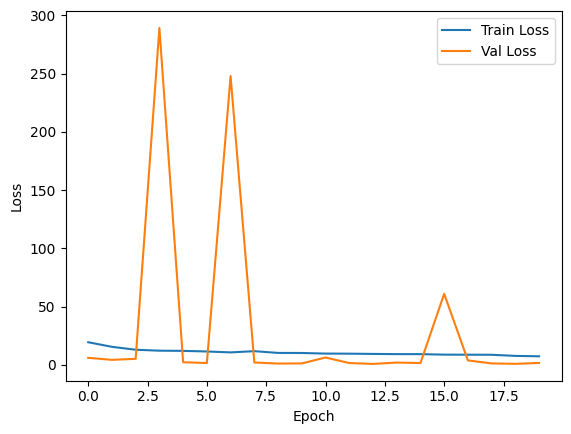

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    f1_score,
    recall_score,
    precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
results = model.evaluate(test_dataset)
print("\nTest Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Get predictions and true labels
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([np.argmax(labels, axis=1) for _, labels in test_dataset])

# Class names
class_names = ['Normal', 'Benign Calc', 'Benign Mass', 'Malignant Calc', 'Malignant Mass']

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Per-class Sensitivity (Recall)
sensitivity_per_class = cm.diagonal() / cm.sum(axis=1)
print("\nSensitivity (Recall) per class:")
for name, sens in zip(class_names, sensitivity_per_class):
    print(f"{name}: {sens:.4f}")

# Per-class Specificity
specificity_per_class = []
for i in range(len(cm)):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

print("\nSpecificity per class:")
for name, spec in zip(class_names, specificity_per_class):
    print(f"{name}: {spec:.4f}")

TP_total = np.trace(cm)
FN_total = np.sum(cm, axis=1) - np.diag(cm)
FP_total = np.sum(cm, axis=0) - np.diag(cm)
TN_total = np.sum(cm) - (TP_total + np.sum(FP_total) + np.sum(FN_total))

overall_sensitivity = TP_total / (TP_total + np.sum(FN_total))
overall_specificity = TN_total / (TN_total + np.sum(FP_total))

print(f"\nOverall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")

# F1 Scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"\nF1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")
